<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.5
## Feature Selection

### Data

**Predict the onset of diabetes based on diagnostic measures.**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

[Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database/download)

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#### 1. Load Data

In [92]:
# Read Data
diabetes_csv = pd.read_csv(r'/Users/annaxu/Documents/Data Science/DATA/diabetes.csv')
diabetes_csv.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### 2. Perform EDA

Perform EDA. Check Null Values. Impute if necessary.

In [95]:
diabetes_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [97]:
#No null values, all columns are numerical

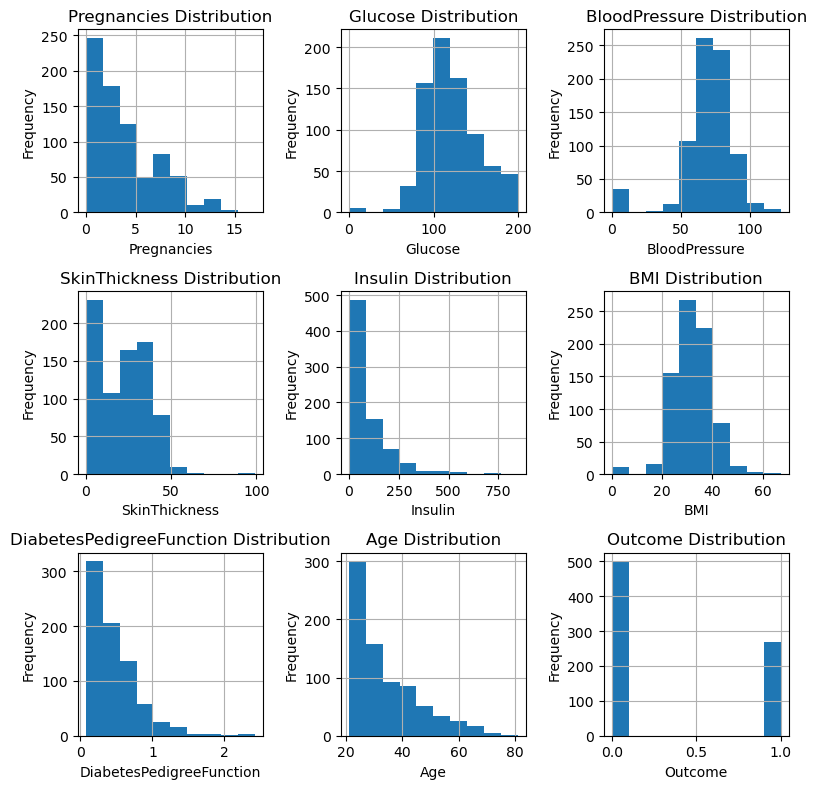

In [99]:
#Plot all columns
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
axs = axs.flatten()

for i, column in enumerate(diabetes_csv.columns):
    
    diabetes_csv[column].hist(ax=axs[i])
    axs[i].set_title(f'{column} Distribution') 
    axs[i].set_xlabel(column) 
    axs[i].set_ylabel('Frequency') 

plt.tight_layout()
plt.show()

In [107]:
#Log transform right-skewed data
def log_transform(df, cols):
    for col in cols:
        min_val = df[col].min()
        shift = abs(min_val) + 1 if min_val <= 0 else 0
        df[col] = np.log(df[col] + shift)

skewed_cols = ['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

log_transform(diabetes_csv, skewed_cols)

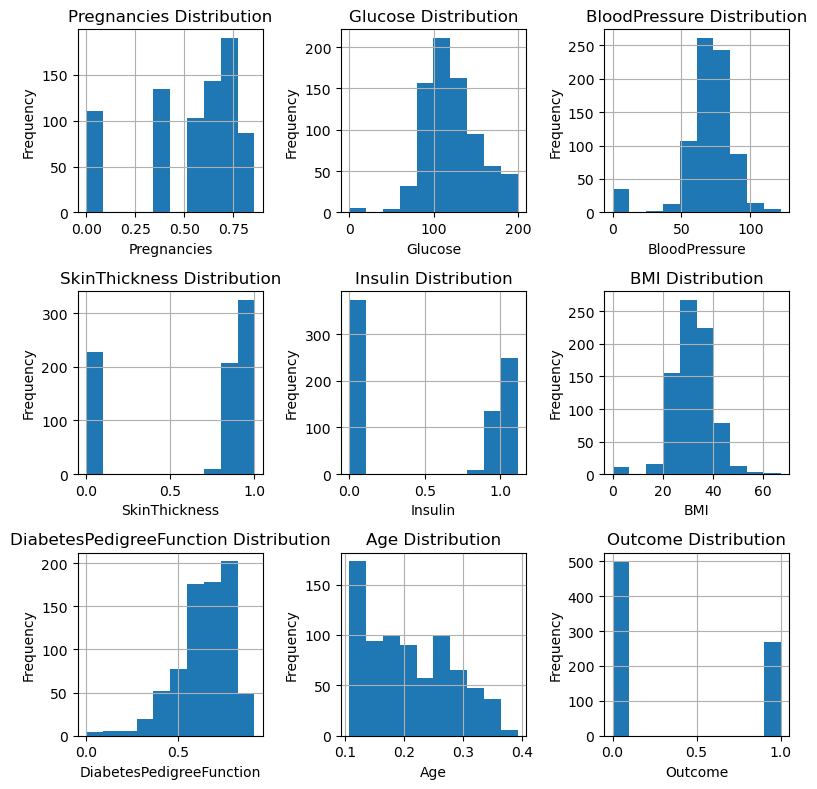

In [109]:
#Recheck plots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
axs = axs.flatten()

for i, column in enumerate(diabetes_csv.columns):
    
    diabetes_csv[column].hist(ax=axs[i])
    axs[i].set_title(f'{column} Distribution') 
    axs[i].set_xlabel(column) 
    axs[i].set_ylabel('Frequency') 

plt.tight_layout()
plt.show()

In [153]:
#Standardise data using MinMaxScaler because we're using chi-square later which requires all feature values to be positive
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(diabetes_csv.drop('Outcome', axis=1))
diabetes_scaled = pd.DataFrame(scaled_data, columns=diabetes_csv.columns[:-1])
diabetes_scaled['Outcome'] = diabetes_csv['Outcome'] 
diabetes_scaled.describe().round(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,0.632,0.608,0.566,0.634,0.466,0.477,0.704,0.351,0.349
std,0.296,0.161,0.159,0.412,0.455,0.117,0.160,0.257,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.493,0.497,0.508,0.000,0.000,0.407,0.620,0.133,0.000
50%,0.729,0.588,0.590,0.886,0.820,0.477,0.727,0.304,0.000
75%,0.854,0.705,0.656,0.916,0.914,0.545,0.827,0.576,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [290]:
#Check correlation with target variable
diabetes_scaled.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.060794,0.097381,-0.108768,-0.106253,-0.075747,-0.049683,0.462713,0.117527
Glucose,0.060794,1.000000,0.152590,-0.038810,0.072185,0.221071,0.104405,0.273893,0.466581
BloodPressure,0.097381,0.152590,1.000000,0.175350,0.085620,0.281805,0.053160,0.245018,0.065068
SkinThickness,-0.108768,-0.038810,0.175350,1.000000,0.660987,0.187824,0.169985,-0.210590,-0.036440
Insulin,-0.106253,0.072185,0.085620,0.660987,1.000000,0.139640,0.194375,-0.199448,-0.025551
BMI,-0.075747,0.221071,0.281805,0.187824,0.139640,1.000000,0.139931,0.089454,0.292695
DiabetesPedigreeFunction,-0.049683,0.104405,0.053160,0.169985,0.194375,0.139931,1.000000,0.045979,0.171256
Age,0.462713,0.273893,0.245018,-0.210590,-0.199448,0.089454,0.045979,1.000000,0.289022
Outcome,0.117527,0.466581,0.065068,-0.036440,-0.025551,0.292695,0.171256,0.289022,1.000000


In [300]:
#Drop SkinThickness as it is highly correlated with insulin (insulin resistance can lead to skin thickness pointing to insulin as the more fundamental factor)
#Keep Age vs pregnancies and glucose vs outcome which have moderate correlations
diabetes_scaled.drop(['SkinThickness'], axis=1, inplace=True)

#### 3. Set Target

- Set `Outcome` as target.
- Set Features

In [302]:
y = diabetes_scaled['Outcome']
X = diabetes_scaled.loc[:, diabetes_scaled.columns != 'Outcome']

#### 4. Select Feature

The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.

##### 4.1 Univariate Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

- SelectKBest removes all but the  highest scoring features
- Use sklearn.feature_selection.chi2 as score function
    > Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.


More Reads:
[Univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

- Create an instance of SelectKBest
    - Use sklearn.feature_selection.chi2 as score_func
    - Use k of your choice
- Fit X, y
- Find top 4 features
- Transform features to a DataFrame

In [304]:
# Create an instance of SelectKBest
kbest = SelectKBest(score_func=chi2, k=4)

In [306]:
# Fit
fit = kbest.fit(X, y)

In [308]:
# Print Score
# Find Top 4 Features
print(feature_scores.head(4))

       Feature  Chi2 Score
7          Age   12.071470
1      Glucose    7.094910
5          BMI    1.902673
0  Pregnancies    1.471131


In [310]:
# Transform X to Features
features = kbest.transform(X)

In [312]:
# Transform features to a dataframe
print(kbest.get_support())
pd.DataFrame(features, columns=X.columns[kbest.get_support()])

[ True  True False False  True False  True]


,Pregnancies,Glucose,BMI,Age
0,0.853782,0.743719,0.500745,0.712846
1,0.493033,0.427136,0.396423,0.360357
2,0.898764,0.919598,0.347243,0.386442
3,0.493033,0.447236,0.418778,0.000000
4,0.000000,0.688442,0.642325,0.411316
...,...,...,...,...
763,0.931121,0.507538,0.490313,0.857518
764,0.646387,0.613065,0.548435,0.241547
765,0.823278,0.608040,0.390462,0.332954
766,0.493033,0.633166,0.448584,0.671580


##### 4.2 Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

More Reads:
[Recursive feature elimination](https://scikit-learn.org/stable/modules/feature_selection.html)

- Use RFE to extract feature
    - use LogisticRegression as estimator
    - Number of n_features_to_select as of your choice
- Fit X, y to RFE
- Find Selected Features

In [315]:
# feature extraction
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=5)
fit = rfe.fit(X, y)

In [317]:
# Print Score
print("RFE score: {:.3%}".format(rfe.score(X,y)))

RFE score: 76.953%


In [319]:
#The model produced the highest score with 5 features.

In [321]:
# Find Features
features = rfe.transform(X)
pd.DataFrame(features, columns=X.columns[rfe.get_support()])

,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,0.743719,0.590164,0.500745,0.827108,0.712846
1,0.427136,0.540984,0.396423,0.714021,0.360357
2,0.919598,0.524590,0.347243,0.838508,0.386442
3,0.447236,0.540984,0.418778,0.491793,0.000000
4,0.688442,0.327869,0.642325,0.994380,0.411316
...,...,...,...,...,...
763,0.507538,0.622951,0.490313,0.501099,0.857518
764,0.613065,0.573770,0.548435,0.706681,0.241547
765,0.608040,0.590164,0.390462,0.621633,0.332954
766,0.633166,0.491803,0.448584,0.712714,0.671580


Intepretation:
- Age, glucose, BMI and pregnancies are the top 4 best individual predictors of diabetes in this dataset.
- Glucose, bloodpressure, BMI, diabetes pedigree function and age are the top 5 best predictors of diabetes given a Logistic Regression model. 



---



---



> > > > > > > > > © 2025 Institute of Data


---



---



